# Preprocess of house prices dataset
In the following notebooks we're going to preprocess the data, that is remove missing variables, transform the variables and treat outliers. We're also going to build a specialized pipeline for those transformations.

In this notebook specifically, model features will be chosen and transformed.

In [1]:
# import dataset and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
pd.plotting.register_matplotlib_converters()
plt.rc('figure', figsize=(16, 6))

In [2]:
orig_data = pd.read_csv("data/train_preprocessed.csv", index_col="Id")

In [3]:
# copying the dataset for analysis
house_data = orig_data.copy()
house_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NoAlley,Reg,Lvl,AllPub,Inside,...,0,NoPool,NoFence,NoFeature,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NoAlley,Reg,Lvl,AllPub,FR2,...,0,NoPool,NoFence,NoFeature,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NoAlley,IR1,Lvl,AllPub,Inside,...,0,NoPool,NoFence,NoFeature,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NoAlley,IR1,Lvl,AllPub,Corner,...,0,NoPool,NoFence,NoFeature,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NoAlley,IR1,Lvl,AllPub,FR2,...,0,NoPool,NoFence,NoFeature,0,12,2008,WD,Normal,250000


Let's first divide the features into separate categories depending if they are nominal, ordinal, interval or ratio variables:

In [4]:
categorical_features = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", 
                        "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "OverallQual", 
                        "OverallCond", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", 
                        "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", 
                        "Heating", "HeatingQC", "CentralAir", "Electrical", "KitchenQual", "Functional", "FireplaceQu", 
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", 'PoolQC', 'Fence', 
                        'MiscFeature', 'SaleType', 'SaleCondition']

numerical_features = ["LotFrontage", "LotArea", "YearBuilt", "YearRemodAdd", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", 
                      "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", 
                      "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", 'Fireplaces', 
                      "GarageYrBlt", "GarageCars", "GarageArea", 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                      'ScreenPorch', 'PoolArea', "MiscVal", 'MoSold', 'YrSold']

def plot_numerical_feature(feature, include_non_positive=True):
    plot_column = X[feature]
    if not include_non_positive:
        plot_column = plot_column[plot_column > 0]
    
    print(f"Description of {feature}")
    print(plot_column.describe(), "\n")
    print(f"Histogram of {feature}")
    plt.figure()
    sns.histplot(data=plot_column)
    plt.show()
    print(f"Kernel density estimation plot of {feature}")
    plt.figure()
    sns.kdeplot(data=plot_column, shade=True)
    plt.show()
    print(f"Box plot of {feature}")   
    plt.figure()
    sns.boxplot(x=plot_column)
    plt.show()

In [5]:
# It might have been beneficial to perform this in the first place, but it's never too late.

nominal = ["MSSubClass", "MSZoning", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", 
           "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", 
           "GarageType", 'MiscFeature', 'SaleType', 'SaleCondition']
ordinal = ["Street", "Alley", "LotShape", "Utilities", "LandSlope", "OverallQual", "OverallCond", "ExterQual", "ExterCond", 
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "CentralAir", "Electrical",
           "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", 'PoolQC', 
           'Fence']
interval = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", 'MoSold', 'YrSold']
ratio = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
         "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr",  
         "KitchenAbvGr", "TotRmsAbvGrd", 'Fireplaces', "GarageCars", "GarageArea", 'WoodDeckSF', 'OpenPorchSF', 
         'EnclosedPorch', '3SsnPorch','ScreenPorch', 'PoolArea', "MiscVal"]
print(len(nominal + ordinal + interval + ratio))

79


Now for the first model I will choose a subset of those features which represent most of the characteristics of a house. I tried to choose variables with high variety.

In [6]:
ord_model = ["OverallQual", "ExterQual", "BsmtQual", "BsmtExposure", "CentralAir", "KitchenQual", "FireplaceQu", "GarageFinish", 
             "GarageCond", "Fence"]
int_model = ["YearBuilt", 'MoSold', 'YrSold']
nom_model = ["MSZoning"]
rat_model = ["LotArea", "MasVnrArea", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "BsmtFullBath", "FullBath", "BedroomAbvGr", 
             "TotRmsAbvGrd", 'Fireplaces', "GarageCars", "GarageArea", 'WoodDeckSF', 'OpenPorchSF']

model_features = nom_model + ord_model + int_model + rat_model

All ratio variables will be treated with standards scaler. 

All interval variables will be normalized to start from 0.

I will encode ord_model features with ordinal encoding. "MSZoning" will be replaced by one-hot encoding. 

Ratio features which are heavily skewed or have large number of outliers will be treated with log transformation.

In [7]:
X = house_data[model_features]
y = house_data["SalePrice"]

In [8]:
log_features = ["LotArea", "MasVnrArea", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GarageArea", 'WoodDeckSF', 
                'OpenPorchSF', "TotRmsAbvGrd"]

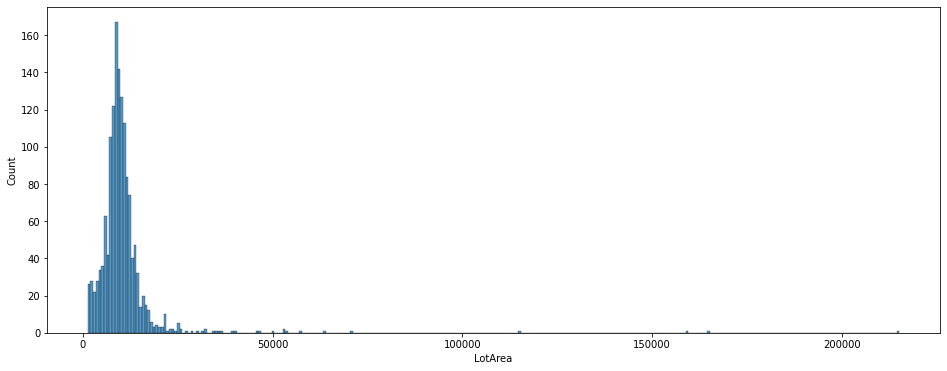

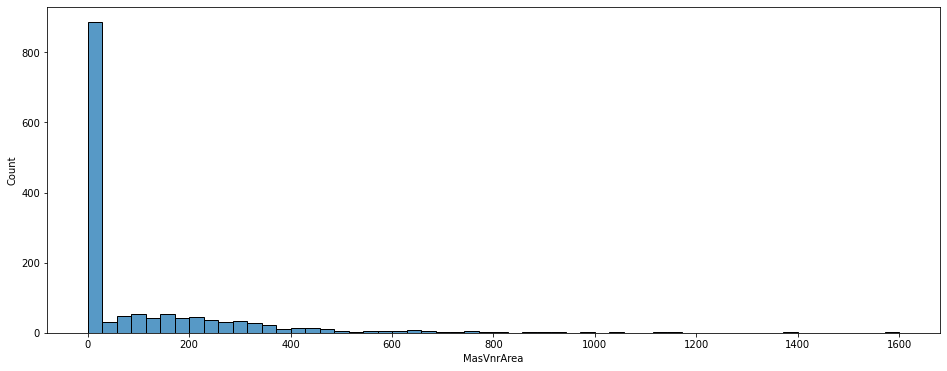

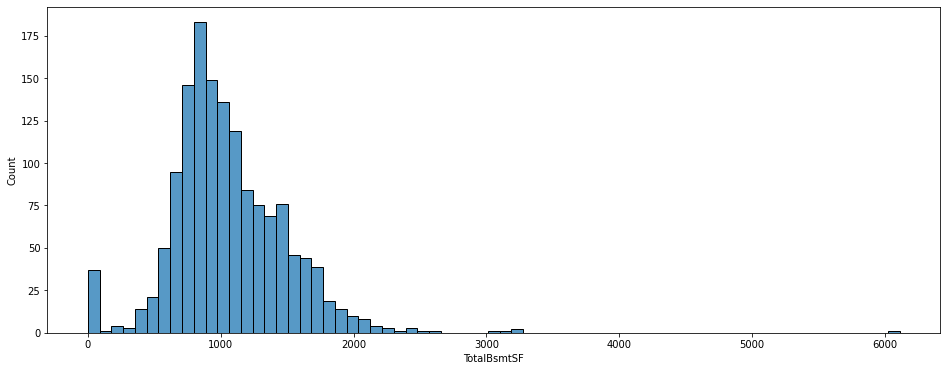

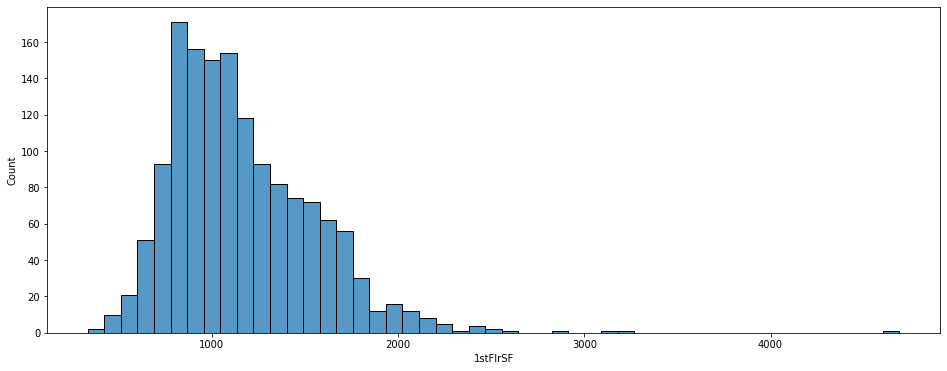

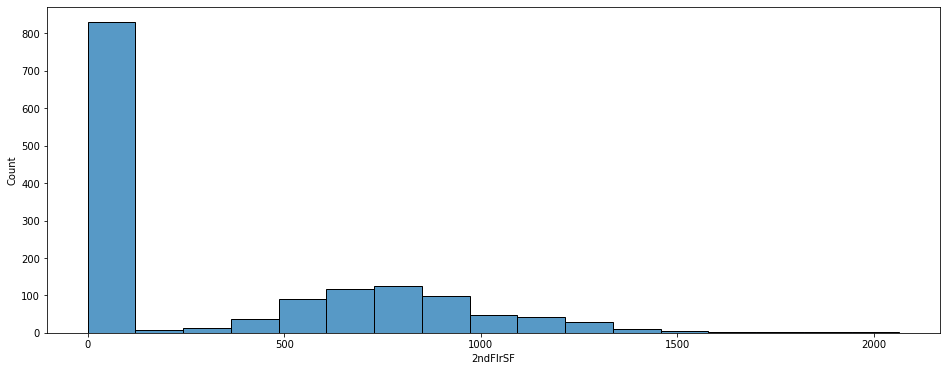

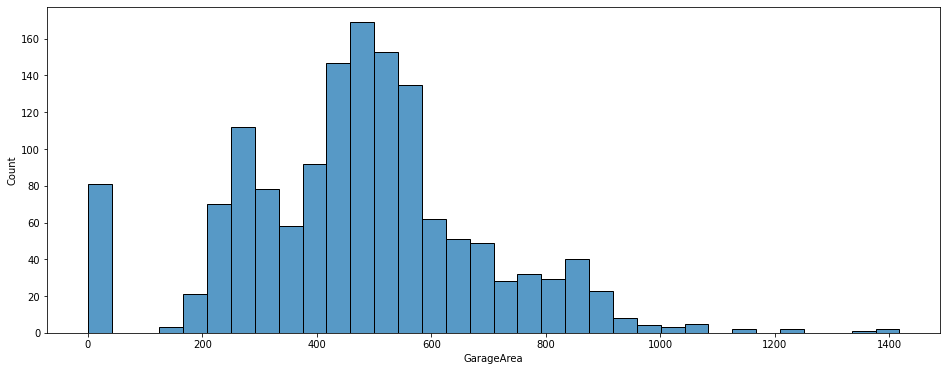

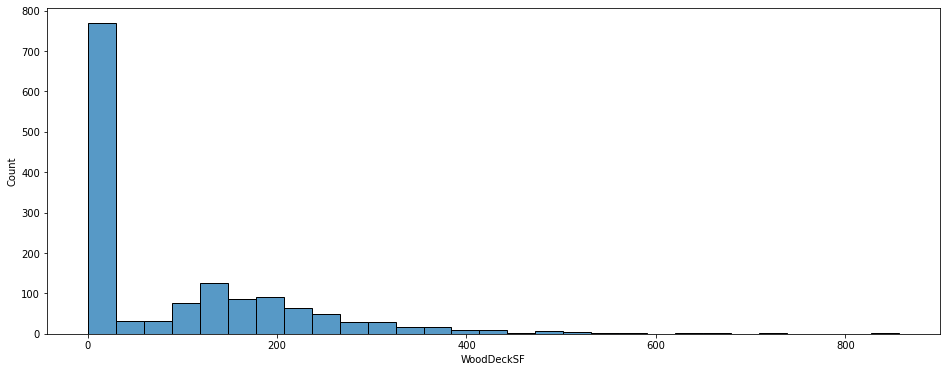

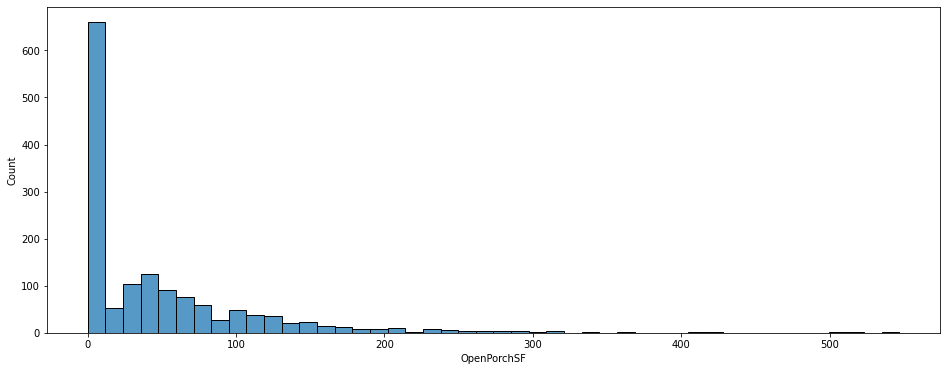

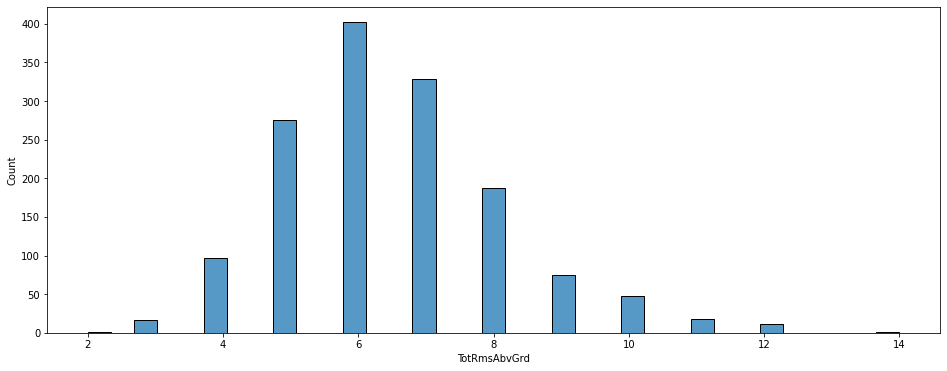

In [9]:
for feature in log_features:
    plt.figure()
    sns.histplot(data=X[feature])
    plt.show()

In comparison the variable with taken logarithm:

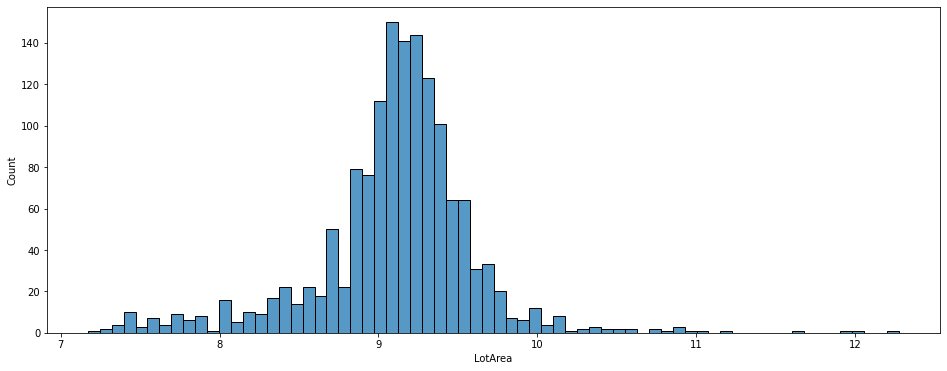

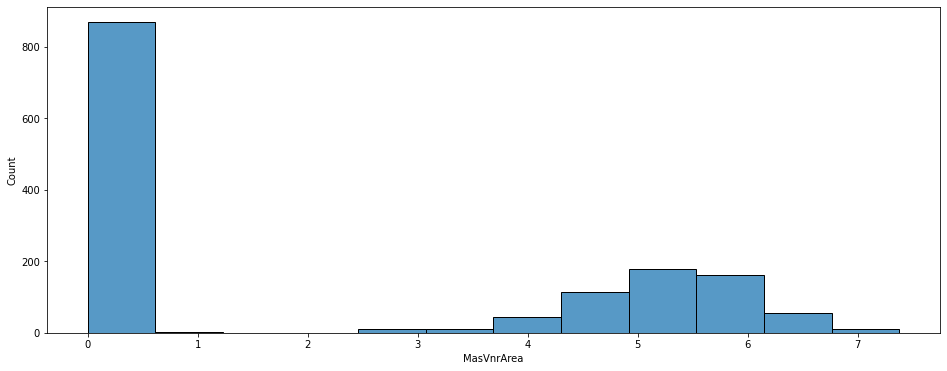

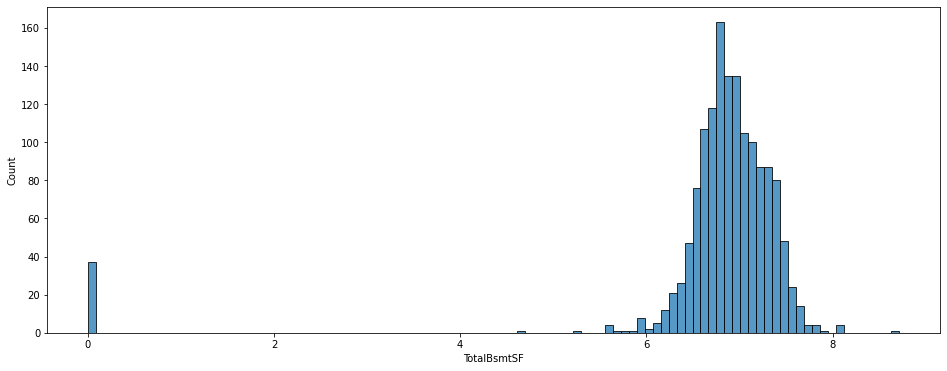

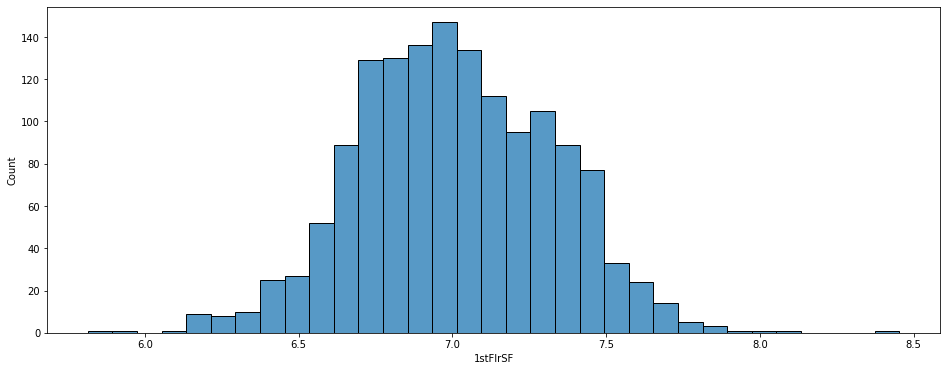

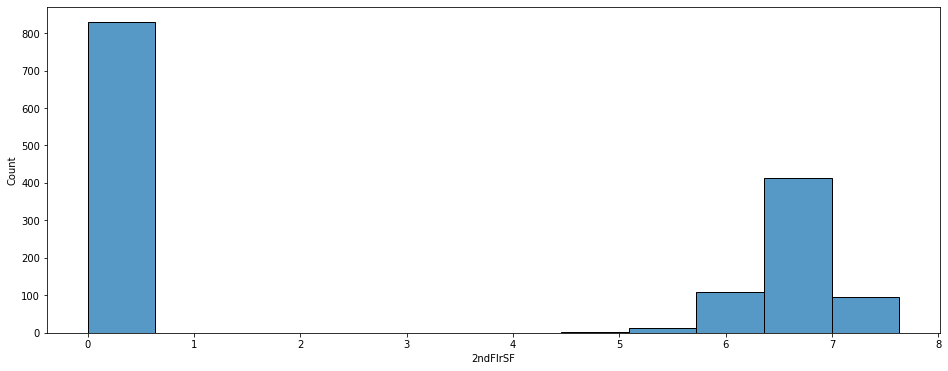

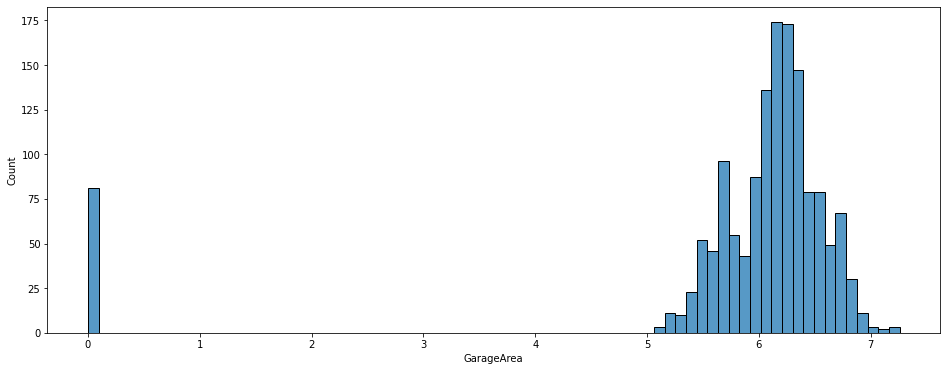

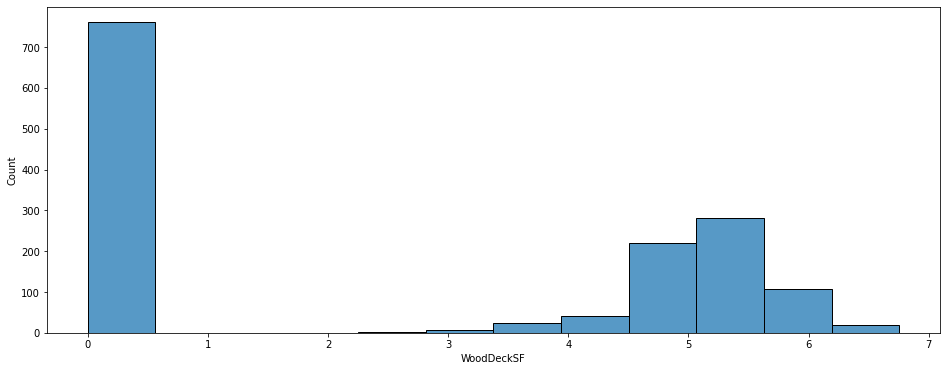

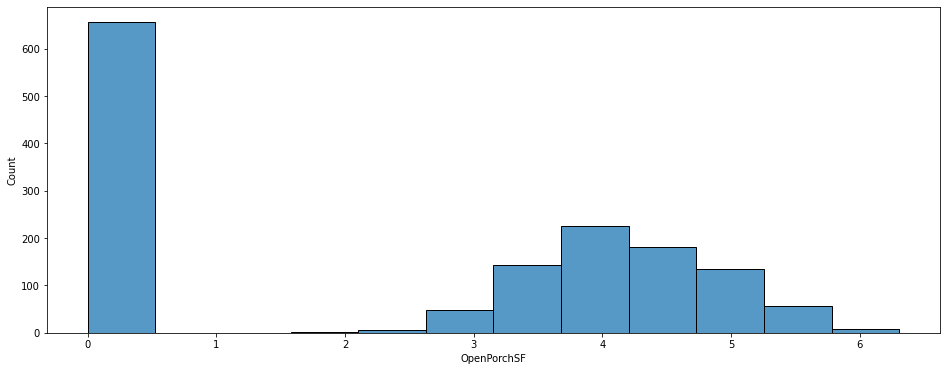

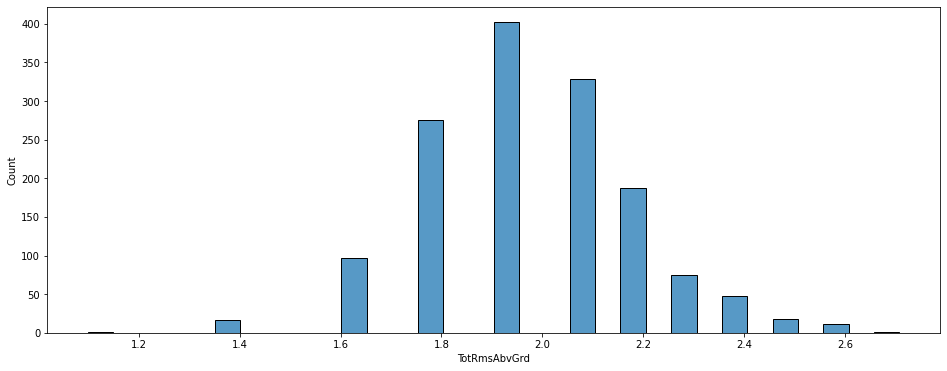

In [10]:
for feature in log_features:
    plt.figure()
    sns.histplot(data=np.log(X[feature] + 1))  # +1 so the 0 is mapped to itself
    plt.show()

Where we see that number of outliers decreased significantly. Couple of notes:
- LotArea still has a lot of outliers, might need to adjust it in future models
- many variables have an accumulation in one point and then a special value of 0 which indicates that house didn't have a specific feature, might need to adjust these variables to remove these special 0 values.

In [11]:
for feature in log_features:
    transformed_column = np.log(X[feature] + 1)
    X['log_' + feature] = transformed_column

<ipython-input-11-e50033307552>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_' + feature] = transformed_column


In [12]:
X = X.drop(log_features, axis=1)

In [13]:
for feature in int_model:
    minimum = X[feature].min()
    X[feature] = X[feature] - minimum

In [14]:
# changing ordinal variables to their ordinal encodings:
ord_model

['OverallQual',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'CentralAir',
 'KitchenQual',
 'FireplaceQu',
 'GarageFinish',
 'GarageCond',
 'Fence']

In [15]:
exter_dict = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1}
bsmt_qual_dict = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "NoBsmt":0}
bsmt_exp_dict = {"Gd":4, "Av":3, "Mn":2, "No":1, "NoBsmt":0}
cent_dict = {"Y":1, "N":0}
kitch_dict = exter_dict
fire_dict = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "NoFireplace":0}
garg_fin_dict = {"Fin":3, "RFn":2, "Unf":1, "NoGarage":0}
garg_cond_dict = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "NoGarage":0}
fence_dict = {"GdPrv":2, "GdWo":2, "MnPrv":1, "MnWw":1, "NoFence":0}

dict_list = [exter_dict, bsmt_qual_dict, bsmt_exp_dict, cent_dict, kitch_dict, fire_dict, 
             garg_fin_dict, garg_cond_dict, fence_dict]
replacement_dict = dict(zip(ord_model[1:], dict_list))

In [16]:
X = X.replace(replacement_dict)

In [17]:
# changing MSZoning with one_hot_encoding
column = X["MSZoning"]
ordinal_encoding = column.replace(dict(zip(sorted(set(column)), range(1, len(sorted(set(column))) + 1))))
one_hot_encoding = ordinal_encoding.apply(
    lambda oe: pd.Series(np.diag(np.ones(len(set(column))))[oe - 1].astype(int))
)
one_hot_encoding.columns = sorted(set(column))
X_one_coded = pd.concat([X, one_hot_encoding], axis=1)

In [18]:
X_one_coded.head()

,MSZoning,OverallQual,ExterQual,BsmtQual,BsmtExposure,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageCond,...,log_2ndFlrSF,log_GarageArea,log_WoodDeckSF,log_OpenPorchSF,log_TotRmsAbvGrd,C (all),FV,RH,RL,RM
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,7,4,4,1,1,4,0,2,3,...,6.751101,6.308098,0.000000,4.127134,2.197225,0,0,0,1,0
2,RL,6,3,4,4,1,3,3,2,3,...,0.000000,6.133398,5.700444,0.000000,1.945910,0,0,0,1,0
3,RL,7,4,4,2,1,4,3,2,3,...,6.765039,6.411818,0.000000,3.761200,1.945910,0,0,0,1,0
4,RL,7,3,3,1,1,4,4,1,3,...,6.629363,6.466145,0.000000,3.583519,2.079442,0,0,0,1,0
5,RL,8,4,4,3,1,4,3,2,3,...,6.960348,6.729824,5.262690,4.442651,2.302585,0,0,0,1,0


In [19]:
X_one_coded = X_one_coded.drop("MSZoning", axis=1)

In [20]:
X_one_coded.head()

,OverallQual,ExterQual,BsmtQual,BsmtExposure,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageCond,Fence,...,log_2ndFlrSF,log_GarageArea,log_WoodDeckSF,log_OpenPorchSF,log_TotRmsAbvGrd,C (all),FV,RH,RL,RM
Id,,,,,,,,,,,,,,,,,,,,,
1,7,4,4,1,1,4,0,2,3,0,...,6.751101,6.308098,0.000000,4.127134,2.197225,0,0,0,1,0
2,6,3,4,4,1,3,3,2,3,0,...,0.000000,6.133398,5.700444,0.000000,1.945910,0,0,0,1,0
3,7,4,4,2,1,4,3,2,3,0,...,6.765039,6.411818,0.000000,3.761200,1.945910,0,0,0,1,0
4,7,3,3,1,1,4,4,1,3,0,...,6.629363,6.466145,0.000000,3.583519,2.079442,0,0,0,1,0
5,8,4,4,3,1,4,3,2,3,0,...,6.960348,6.729824,5.262690,4.442651,2.302585,0,0,0,1,0


In [21]:
X_train,X_test,y_train,y_test = train_test_split(X_one_coded,y,random_state=37,test_size=0.2)

At last let's rescale ratio variables:

In [22]:
ratio_log_features = ["log_LotArea", "log_MasVnrArea", "log_TotalBsmtSF", "log_1stFlrSF", "log_2ndFlrSF", "BsmtFullBath", 
                      "FullBath", "BedroomAbvGr", "log_TotRmsAbvGrd", 'Fireplaces', "GarageCars", "log_GarageArea", 
                      'log_WoodDeckSF', 'log_OpenPorchSF']

scaler = StandardScaler()
scaler.fit(X_train[ratio_log_features])
X_train[ratio_log_features] = scaler.transform(X_train[ratio_log_features])

<ipython-input-22-9522e1323ae3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[ratio_log_features] = scaler.transform(X_train[ratio_log_features])
c:\users\lenovo\appdata\local\programs\python\python38_jupyter\lib\site-packages\pandas\core\indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [23]:
X_train.head()

,OverallQual,ExterQual,BsmtQual,BsmtExposure,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageCond,Fence,...,log_2ndFlrSF,log_GarageArea,log_WoodDeckSF,log_OpenPorchSF,log_TotRmsAbvGrd,C (all),FV,RH,RL,RM
Id,,,,,,,,,,,,,,,,,,,,,
1322,3,3,0,0,0,3,0,1,2,0,...,-0.876356,-0.102902,-0.964385,-1.074768,-1.777131,0,0,0,1,0
1333,4,3,3,2,1,3,4,1,2,0,...,-0.876356,-0.100506,-0.964385,-1.074768,-2.818483,0,0,0,1,0
1183,10,4,5,3,1,5,3,3,3,1,...,1.442933,0.615301,1.023039,0.959536,1.902395,0,0,0,1,0
776,6,3,5,1,1,3,0,3,3,0,...,-0.876356,0.146283,-0.964385,1.492145,-0.926283,0,0,0,0,1
1000,7,4,4,3,1,4,0,2,3,0,...,-0.876356,0.441460,0.836147,0.846721,-0.206902,0,0,0,1,0


And the same with X_test:

In [24]:
scaler = StandardScaler()
scaler.fit(X_test[ratio_log_features])
X_test[ratio_log_features] = scaler.transform(X_test[ratio_log_features])

<ipython-input-24-adfb673ae35f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[ratio_log_features] = scaler.transform(X_test[ratio_log_features])
c:\users\lenovo\appdata\local\programs\python\python38_jupyter\lib\site-packages\pandas\core\indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [25]:
X_test.head()

,OverallQual,ExterQual,BsmtQual,BsmtExposure,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageCond,Fence,...,log_2ndFlrSF,log_GarageArea,log_WoodDeckSF,log_OpenPorchSF,log_TotRmsAbvGrd,C (all),FV,RH,RL,RM
Id,,,,,,,,,,,,,,,,,,,,,
493,6,4,4,1,1,3,0,2,3,0,...,1.155179,0.181912,-0.878866,-1.065606,0.874385,0,0,0,1,0
66,8,4,5,3,1,4,4,2,3,0,...,1.337900,0.642890,1.136582,1.253122,1.369224,0,0,0,1,0
890,6,3,3,1,1,3,3,2,3,0,...,-0.845502,0.291442,-0.878866,-1.065606,-0.305943,0,0,0,1,0
1174,5,3,3,1,1,5,4,0,0,1,...,1.242495,-3.898934,0.964052,-1.065606,2.601448,0,0,0,1,0
1207,4,3,3,1,1,3,0,1,3,1,...,-0.845502,0.107519,-0.878866,0.670343,-1.029930,0,0,1,0,0


In [26]:
# Let's save those values for model building:
X_train.to_csv("data/X_train.csv")
X_test.to_csv("data/X_test.csv")
y_train.to_csv("data/y_train.csv")
y_test.to_csv("data/y_test.csv")